In [101]:
import json
import os
import sys

import branca
import branca.colormap as cm
import geopandas as gpd
import numpy as np
import pandas as pd

sys.path.insert(0, "../src")
from BrusselsMap import BrusselsMap
from GeoJsonHandler import GeoJsonHandler
from OSMGeoJsonHandler import OSMGeoJsonHandler

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

import warnings
warnings.filterwarnings('ignore')

In [102]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## DemandMatrix Segmentation

In [103]:
# Energy demand per neighorhood
demand = pd.read_csv("../data/final_data/DemandEnergy.csv")

# Residential - Non Residential segmentation
res_seg = pd.read_csv("../data/final_data/osm/residential-nonResidential.csv")

# Non Residential segmentation
nonres_seg = pd.read_csv("../data/final_data/osm/repartition.csv")
nonres_seg = pd.merge(res_seg[['NAME_FRE']], nonres_seg, on='NAME_FRE', how='left')
nonres_seg.fillna(0, inplace=True)

# Private parking ratio per neighborhood
parking = pd.read_csv("../data/final_data/parkings_ratio.csv")
parking.sort_values(by=['NAME_FRE'], inplace=True)
parking.iloc[140,10] = 1 #Set value of VIVIER D'OIE to 1 (exceeding 1)

# Some preprocessing
demand = demand[["NAME_FRE", "regularEnergyDemand", "irregularEnergyDemand"]]
demand.rename(
    columns={"regularEnergyDemand": "REG", "irregularEnergyDemand": "IRREG"},
    inplace=True,
)
res_seg = res_seg[["NAME_FRE", "LENGTH_res_prop"]].rename(
    columns={"LENGTH_res_prop": "RES_PROP"}
)

Legend for the next dataframe:

- RES_REG_DEM : Residential Regular Demand (in Kwh/day)
- RES_IRREG_DEM : Residential Irregular Demand (in Kwh/day)
- NONRES_REG_DEM : Non Residential Regular Demand (in Kwh/day)
- NONRES_IRREG_DEM : Non Residential Irregular Demand (in Kwh/day)
- RES_REG_DEM_PPCOR : Residential Regular Demand after Private Parking correction
- RES_IRREG_DEM_PPCOR : Residential Irregular Demand after Private Parking correction

## Residential Segmentation

Residential Regular/Irregular Demand = Demand * Residential_Segmentation_Ratio
Non Residential Regular/Irregular Demand = Demand * (1 - Residential_Segmentation_Ratio)

In [104]:
# Regular demand
demand["RES_REG_DEM"] = demand["REG"] * res_seg["RES_PROP"]
demand["NONRES_REG_DEM"] = demand["REG"] * (1 - res_seg["RES_PROP"])

# Irregular demand
demand["RES_IRREG_DEM"] = demand["IRREG"] * res_seg["RES_PROP"]
demand["NONRES_IRREG_DEM"] = demand["IRREG"] * (1 - res_seg["RES_PROP"])

## Private parking correction on residential Segmentation

Only the residential demand is affected by the PPR Ratio.

In [105]:
# Regular Demand
demand["RES_REG_DEM_PPCOR"] = demand["RES_REG_DEM"] * parking["PRIVATE/HOUS"]

# Irregular Demand
demand["RES_IRREG_DEM_PPCOR"] = demand["RES_IRREG_DEM"] * parking["PRIVATE/HOUS"]

## Non residential demand segmentation

Let's make the assumption:
- office = Normal
- health = Semi Rapid
- culture = Semi Rapid
- education = Semi Rapid
- sustenance = Rapid
- tourism = Rapid


Assumption : 
- Example: at least 5% of non residential demand charging offer should be rapid. ---> How can I find that number? 
    - (convey x % from SEMI-RAPID to RAPID)

In [106]:
# nonres_seg["NORMAL"] = (
#     nonres_seg["PROPORTION_office"]
# )

# nonres_seg["SEMI_RAPID"] = (
#     nonres_seg["PROPORTION_health"]
#     + nonres_seg["PROPORTION_education"]
#     + nonres_seg["PROPORTION_shop"]
#     + nonres_seg["PROPORTION_sustenance"]
#     + nonres_seg["PROPORTION_culture"]
# )
# nonres_seg["RAPID"] = nonres_seg[["PROPORTION_tourism"]]

## Second alternative here: we normalize by the neighborhood area
nonres_seg["NORMAL"] = (
    nonres_seg["AREA_office"]
)

nonres_seg["SEMI_RAPID"] = (
    nonres_seg["AREA_health"]
    + nonres_seg["AREA_education"]
    + nonres_seg["AREA_shop"]
    + nonres_seg["AREA_culture"]
)

nonres_seg["RAPID"] = (
    nonres_seg["AREA_tourism"]
    + nonres_seg["AREA_sustenance"]
)


In [107]:
nonres_seg["POI_AREA"]= nonres_seg["RAPID"] + nonres_seg["NORMAL"]+ nonres_seg["SEMI_RAPID"] 


In [108]:
nonres_seg["POI_AREA"]= nonres_seg["RAPID"] + nonres_seg["NORMAL"]+ nonres_seg["SEMI_RAPID"] 
# Normalize by area (we currently have the total areas under 'NORMAL, 'RAPID', 'SEMI-RAPID' - So we need to compute the ratio of total area. 
# Therefore, we divide the area of each type of amenity by the area of the neighborhood. Wouldn't it make more sense to divide by the total area of amenities?
# nonres_seg = pd.merge(nonres_seg, parking[['NAME_FRE','AREA']], on='NAME_FRE', how='left')

nonres_seg['NORMAL'] = nonres_seg['NORMAL'].div(nonres_seg['POI_AREA'])
nonres_seg['SEMI_RAPID'] = nonres_seg['SEMI_RAPID'].div(nonres_seg['POI_AREA'])
nonres_seg['RAPID'] = nonres_seg['RAPID'].div(nonres_seg['POI_AREA'])

# Rescale to values between [0,1] and sum of each non residential proportion to 1
# prop_area = nonres_seg[['NORMAL','SEMI_RAPID','RAPID']]
# nonres_seg[['NORMAL','SEMI_RAPID','RAPID']] = prop_area.div(prop_area.sum(axis=1), axis=0)

# Fillna again
nonres_seg.fillna(0, inplace=True)

In [109]:
nonres_seg.head(10)

NAME_FRE  TOTAL_culture  TOTAL_education  \
0                    ALTITUDE 100            0.0              5.0   
1       ANDERLECHT CENTRE - WAYEZ            5.0              6.0   
2                      ANNEESSENS            2.0              7.0   
3                AUDERGHEM CENTRE            5.0              5.0   
4              AVENUE LEOPOLD III            0.0              3.0   
5                      BAS FOREST            7.0              2.0   
6                       BASILIQUE            1.0              3.0   
7             BEGUINAGE - DIXMUDE           12.0              4.0   
8    BERCHEM SAINTE-AGATHE CENTRE            4.0              4.0   
9  BERCKMANS - HOTEL DES MONNAIES            3.0              6.0   

   TOTAL_health  TOTAL_office  TOTAL_shop  TOTAL_sustenance  TOTAL_tourism  \
0           0.0           0.0         8.0               4.0            0.0   
1           0.0           0.0        22.0              16.0            7.0   
2           1.0           0.0        19.0              12.0           11.0   
3           0.0           4.0        14.0              21.0            3.0   
4           0.0           2.0         5.0               4.0            3.0   
5           0.0           3.0        16.0               9.0            2.0   
6           1.0           1.0        13.0              11.0            6.0   
7           0.0           7.0        41.0              60.0           18.0   
8           0.0           2.0        23.0              15.0            0.0   
9           0.0           9.0        35.0              63.0           10.0   

   AREA_culture  AREA_education  AREA_health  AREA_office  AREA_shop  \
0      0.000000        0.023356     0.000000     0.000000   0.004497   
1      0.003574        0.029202     0.000000     0.000000   0.004571   
2      0.001179        0.045785     0.011116     0.000000   0.003728   
3      0.002948        0.018330     0.000000     0.001188   0.025064   
4      0.000000        0.027820     0.000000     0.000663   0.013963   
5      0.004988        0.004527     0.000000     0.000995   0.002908   
6      0.000590        0.017482     0.011116     0.000332   0.001704   
7      0.016261        0.011447     0.000000     0.002322   0.006261   
8      0.001998        0.041413     0.000000     0.006996   0.032725   
9      0.001198        0.024666     0.000000     0.002847   0.007834   

   AREA_sustenance  AREA_tourism  AREA_total  TOTAL_total  PROPORTION_health  \
0         0.000724      0.000000    0.028576         17.0           0.000000   
1         0.002517      0.001661    0.041525         56.0           0.000000   
2         0.001700      0.002561    0.066070         52.0           0.168249   
3         0.004269      0.000517    0.052316         52.0           0.000000   
4         0.000485      0.004277    0.047209         17.0           0.000000   
5         0.001449      0.001237    0.016104         39.0           0.000000   
6         0.001730      0.001526    0.034479         36.0           0.322399   
7         0.009643      0.008090    0.054025        142.0           0.000000   
8         0.002755      0.000000    0.085888         48.0           0.000000   
9         0.010553      0.002929    0.050025        126.0           0.000000   

   PROPORTION_culture  PROPORTION_education  PROPORTION_shop  \
0            0.000000              0.817326         0.157350   
1            0.086073              0.703231         0.110070   
2            0.017846              0.692979         0.056425   
3            0.056343              0.350372         0.479092   
4            0.000000              0.589292         0.295771   
5            0.309758              0.281087         0.180587   
6            0.017098              0.507025         0.049424   
7            0.300991              0.211893         0.115898   
8            0.023267              0.482174         0.381025   
9            0.023939              0.493059         0.156591   

   PROPORTION_sustenance  P

In [110]:
neighborhoods = ["MATONGE", "QUARTIER ROYAL", "QUARTIER EUROPEEN", "CHANT D'OISEAU"]
nonres_seg[nonres_seg["NAME_FRE"].isin(neighborhoods)][["NAME_FRE","NORMAL", "SEMI_RAPID", "RAPID"]]

NAME_FRE    NORMAL  SEMI_RAPID     RAPID
21      CHANT D'OISEAU  0.039774    0.938405  0.021821
82             MATONGE  0.079116    0.719846  0.201038
110  QUARTIER EUROPEEN  0.783797    0.100128  0.116075
113     QUARTIER ROYAL  0.460516    0.263480  0.276004

In [111]:
res_seg.head()

NAME_FRE  RES_PROP
0               ALTITUDE 100  0.784178
1  ANDERLECHT CENTRE - WAYEZ  0.638035
2                 ANNEESSENS  0.010439
3           AUDERGHEM CENTRE  0.433405
4         AVENUE LEOPOLD III  0.567605

Example of segmentation:

- Resid: 90%   --> 0.9*0.4 = 0.36 
- Parking: 60% --> 0.9*0.6 = 0.54


Non-Resid: 10% - POI:
- normal: 35% --> 0.10 * 0.35 = 0.035
- semi:   50% --> 0.10 * 0.50 = 0.050
- fast:   15% --> 0.10 * 0.15 = 0.015

In [154]:
segmentation = pd.merge(res_seg, parking[['NAME_FRE','PRIVATE/HOUS']], on='NAME_FRE', how='left')
segmentation = pd.merge(segmentation, nonres_seg[['NAME_FRE','NORMAL','SEMI_RAPID','RAPID']], on='NAME_FRE', how='left')
segmentation['RES_NORMAL'] = segmentation['RES_PROP'].multiply(1-segmentation['PRIVATE/HOUS'], axis="index") # residential proportion * (1-private parking)
segmentation['PARKING'] = segmentation['RES_PROP'].multiply(segmentation['PRIVATE/HOUS'], axis="index") # residential proportion * private parking
segmentation[['NORMAL', 'SEMI_RAPID','RAPID']] = segmentation[['NORMAL', 'SEMI_RAPID','RAPID']].multiply(1-segmentation['RES_PROP'], axis="index")
segmentation['TOTAL'] = segmentation["RES_NORMAL"] + segmentation["NORMAL"] + segmentation["SEMI_RAPID"] + segmentation["RAPID"] + segmentation["PARKING"]
segmentation.drop(columns=['PRIVATE/HOUS'], inplace=True)
segmentation.head()

NAME_FRE  RES_PROP    NORMAL  SEMI_RAPID     RAPID  \
0               ALTITUDE 100  0.784178  0.000000    0.210357  0.005465   
1  ANDERLECHT CENTRE - WAYEZ  0.638035  0.000000    0.325542  0.036423   
2                 ANNEESSENS  0.010439  0.000000    0.925733  0.063828   
3           AUDERGHEM CENTRE  0.433405  0.012871    0.501893  0.051830   
4         AVENUE LEOPOLD III  0.567605  0.006077    0.382697  0.043621   

   RES_NORMAL   PARKING  TOTAL  
0    0.669747  0.114431    1.0  
1    0.556742  0.081293    1.0  
2    0.009748  0.000691    1.0  
3    0.341471  0.091934    1.0  
4    0.483451  0.084154    1.0

In [165]:
segmentation[segmentation["NAME_FRE"].isin(neighborhoods)]

NAME_FRE  RES_PROP    NORMAL  SEMI_RAPID     RAPID  RES_NORMAL  \
21      CHANT D'OISEAU  0.813429  0.007421    0.175079  0.004071    0.373455   
82             MATONGE  0.804339  0.015480    0.140846  0.039335    0.774096   
110  QUARTIER EUROPEEN  0.497927  0.393524    0.050272  0.058278    0.435118   
113     QUARTIER ROYAL  0.365795  0.292061    0.167100  0.175043    0.365795   

      PARKING  TOTAL  
21   0.439975    1.0  
82   0.030243    1.0  
110  0.062808    1.0  
113  0.000000    1.0

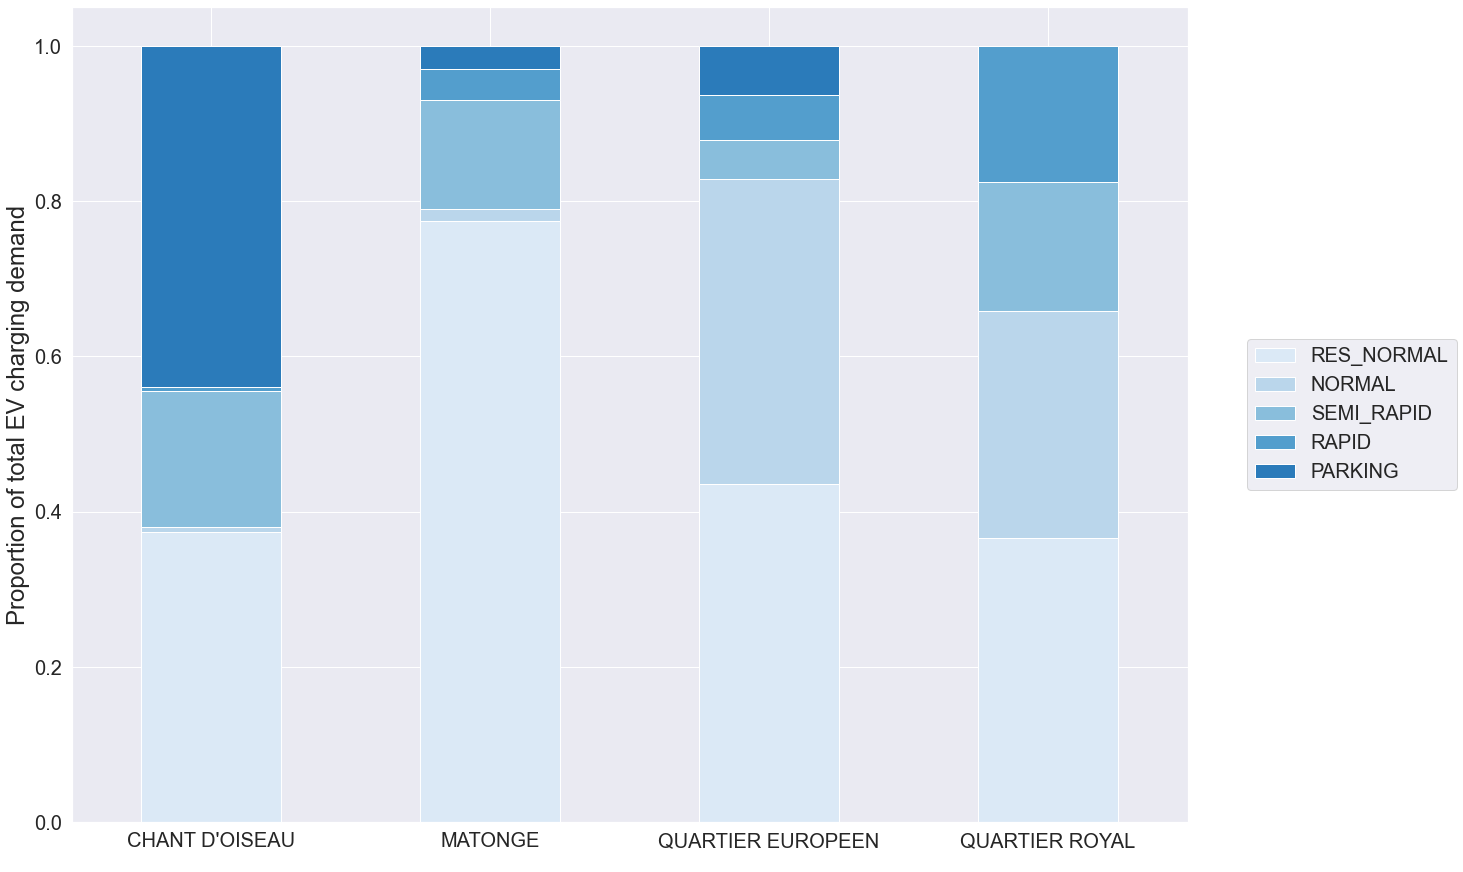

In [198]:
sns.set(rc={'figure.figsize':(20,15)})


viz_data = segmentation[segmentation["NAME_FRE"].isin(neighborhoods)][["NAME_FRE", "RES_NORMAL", "NORMAL", "SEMI_RAPID", "RAPID", "PARKING"]]
viz_data.set_index("NAME_FRE", inplace=True)
viz_data.head()

# create stacked bar chart for students DataFrame
sns.set_palette("Blues")
plot = viz_data.plot(kind='bar', stacked=True, fontsize=20)#, color=['gray', 'lightblue', "blue", "darkblue"])
 
# Add Title and Labels
plt.ylabel('Proportion of total EV charging demand', fontsize=24)
plt.xlabel(' ')
plt.xticks(rotation=0)
plt.setp(plot.get_legend().get_texts(), fontsize='20') # for legend text

plot.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize=20)

# Save fig
r_path = r"../data/osm/overpass-turbo/img/segmentation_proportions.png"
fig = plot.get_figure()
fig.savefig(r_path,  bbox_inches='tight')

In [40]:
# Set values of parcs to 0
#Also do this for cemeteries

parcs = [
    "FORET DE SOIGNES",
    "SCHEUTBOS",
    "PARC WOLVENDAEL",
    "BOIS DE LA CAMBRE",
    "BOIS DU LAARBEEK - POELBOS",
    "PARC LEOPOLD",
    "DOMAINE ROYAL LAEKEN",
    "PARC BAUDOUIN - DIELEGEMBOS",
    "PARC DE LA WOLUWE",
    "PARC DES ETANGS",
    "PARC DUDEN - PARC DE FOREST",
    "PARC ASTRID",
    "PARC DE FOREST",
    "PARC ELISABETH",
    "PARC FORESTIER",
    "PARC JOSAPHAT",
    "PARC LEOPOLD",
    "PARC MARIE-JOSE",
    "PARC WOLVENDAEL",
    "CIMETIERE SAINT-GILLES",
    "CIMETIERE D'IXELLES",
    "CIMETIERE DE BRUXELLES", 
]

segmentation.loc[segmentation['NAME_FRE'].isin(parcs), ['NORMAL','SEMI_RAPID','RAPID','PARKING']] = 0

## Choropleth Map
Let's plot these results on a Choropleth Math

In [41]:
#Load geodata
r_path = r"../data/final_data/sector.json"
path = os.path.join(os.getcwd(), r_path)
sectors = GeoJsonHandler(path, "NAME_FRE")

#Add data
sectors.add_property(segmentation, 'NORMAL')
sectors.add_property(segmentation, 'SEMI_RAPID')
sectors.add_property(segmentation, 'RAPID')

Successfully added NORMAL property to geodata.
Successfully added SEMI_RAPID property to geodata.
Successfully added RAPID property to geodata.


In [42]:
mymap = BrusselsMap(sectors, 800, 800, tile='stamenwatercolor')

attribute = 'NORMAL'
legend = f"Choropleth Map of Brussels showing the {attribute}"
nbr_steps = 6
colormap_type = "step"
mymap.add_choropleth_style2(segmentation[["NAME_FRE", attribute]], legend, nbr_steps, colormap_type)

#Add special points markers
viv = sectors.gdf[sectors.gdf['NAME_FRE']=="VIVIER D'OIE"][['NAME_FRE','CENTER_LONG','CENTER_LAT']]
mymap.add_markers(data=viv, icon="home", color="lightblue")

hom = sectors.gdf[sectors.gdf['NAME_FRE']=="KRIEKENPUT - HOMBORCH - VERREWINKEL"][['NAME_FRE','CENTER_LONG','CENTER_LAT']]
mymap.add_markers(data=hom, icon="home", color="darkblue")

hot = sectors.gdf[sectors.gdf['NAME_FRE']=="BERCKMANS - HOTEL DES MONNAIES"][['NAME_FRE','CENTER_LONG','CENTER_LAT']]
mymap.add_markers(data=hot, icon="building", color="black")

ind = sectors.gdf[sectors.gdf['NAME_FRE']=="INDUSTRIE NORD"][['NAME_FRE','CENTER_LONG','CENTER_LAT']]
mymap.add_markers(data=ind, icon="shopping-basket", color="purple")

delta = sectors.gdf[sectors.gdf['NAME_FRE']=="DELTA"][['NAME_FRE','CENTER_LONG','CENTER_LAT']]
mymap.add_markers(data=delta, icon="h-square", color="lightgreen")

erasme = sectors.gdf[sectors.gdf['NAME_FRE']=="VOGELENZANG - ERASME"][['NAME_FRE','CENTER_LONG','CENTER_LAT']]
mymap.add_markers(data=erasme, icon="h-square", color="darkgreen")

mymap.map

In [43]:
o_path = r"../data/outputs/maps/"
mymap.map.save(os.path.join(o_path, "NORMAL_SHOT1.html")) # to HTML

In [44]:
mymap = BrusselsMap(sectors, 800, 800, tile='stamenwatercolor')

attribute = 'SEMI_RAPID'
legend = f"Choropleth Map of Brussels showing the {attribute}"
nbr_steps = 6
colormap_type = "step"
mymap.add_choropleth_style2(segmentation[["NAME_FRE", attribute]], legend, nbr_steps, colormap_type)

#Add special points markers
viv = sectors.gdf[sectors.gdf['NAME_FRE']=="VIVIER D'OIE"][['NAME_FRE','CENTER_LONG','CENTER_LAT']]
mymap.add_markers(data=viv, icon="home", color="lightblue")

hot = sectors.gdf[sectors.gdf['NAME_FRE']=="BERCKMANS - HOTEL DES MONNAIES"][['NAME_FRE','CENTER_LONG','CENTER_LAT']]
mymap.add_markers(data=hot, icon="building", color="black")

hom = sectors.gdf[sectors.gdf['NAME_FRE']=="KRIEKENPUT - HOMBORCH - VERREWINKEL"][['NAME_FRE','CENTER_LONG','CENTER_LAT']]
mymap.add_markers(data=hom, icon="home", color="darkblue")

ind = sectors.gdf[sectors.gdf['NAME_FRE']=="INDUSTRIE NORD"][['NAME_FRE','CENTER_LONG','CENTER_LAT']]
mymap.add_markers(data=ind, icon="shopping-basket", color="purple")

delta = sectors.gdf[sectors.gdf['NAME_FRE']=="DELTA"][['NAME_FRE','CENTER_LONG','CENTER_LAT']]
mymap.add_markers(data=delta, icon="h-square", color="lightgreen")

erasme = sectors.gdf[sectors.gdf['NAME_FRE']=="VOGELENZANG - ERASME"][['NAME_FRE','CENTER_LONG','CENTER_LAT']]
mymap.add_markers(data=erasme, icon="h-square", color="darkgreen")

mymap.map

In [45]:
o_path = r"../data/outputs/maps/"
mymap.map.save(os.path.join(o_path, "SEMI_RAPID_SHOT1.html")) # to HTML

In [46]:
segmentation[segmentation['NAME_FRE'] == 'CINQUANTENAIRE']

segmentation.loc[segmentation['NAME_FRE'].isin(['CINQUANTENAIRE']), ['RAPID']] = 0.1

In [47]:
colormap = cm.LinearColormap(
    ["white", "lightyellow", "#FFD580", "#ffaf42", "red", "darkred"], index=[0, 0.01, 0.05, 0.1, 0.2, 0.3]
)
colormap

In [48]:
mymap = BrusselsMap(sectors, 800, 800, tile='stamenwatercolor')

attribute = 'RAPID'
legend = f"Choropleth Map of Brussels showing the {attribute}"
nbr_steps = 6
colormap_type = "manual"
mymap.add_choropleth_style2(segmentation[["NAME_FRE", attribute]], legend, nbr_steps, colormap_type, colormap=colormap)

#Add special points markers
viv = sectors.gdf[sectors.gdf['NAME_FRE']=="VIVIER D'OIE"][['NAME_FRE','CENTER_LONG','CENTER_LAT']]
mymap.add_markers(data=viv, icon="star-o", color="lightblue")

hot = sectors.gdf[sectors.gdf['NAME_FRE']=="BERCKMANS - HOTEL DES MONNAIES"][['NAME_FRE','CENTER_LONG','CENTER_LAT']]
mymap.add_markers(data=hot, icon="star-o", color="darkred")

hom = sectors.gdf[sectors.gdf['NAME_FRE']=="KRIEKENPUT - HOMBORCH - VERREWINKEL"][['NAME_FRE','CENTER_LONG','CENTER_LAT']]
mymap.add_markers(data=hom, icon="star-o", color="darkblue")

ind = sectors.gdf[sectors.gdf['NAME_FRE']=="INDUSTRIE NORD"][['NAME_FRE','CENTER_LONG','CENTER_LAT']]
mymap.add_markers(data=ind, icon="star-o", color="purple")

delta = sectors.gdf[sectors.gdf['NAME_FRE']=="DELTA"][['NAME_FRE','CENTER_LONG','CENTER_LAT']]
mymap.add_markers(data=delta, icon="star-o", color="lightgreen")

erasme = sectors.gdf[sectors.gdf['NAME_FRE']=="VOGELENZANG - ERASME"][['NAME_FRE','CENTER_LONG','CENTER_LAT']]
mymap.add_markers(data=erasme, icon="star-o", color="darkgreen")

mymap.map